# Pix2Pix - Conditional GAN for Segmented to Real Image Translation

In this notebook, we use Conditional GAN architecture for translating segmented images to real images in street view of Cityscapes dataset.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
from transformers import get_cosine_schedule_with_warmup

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

## GAN

*Generative Adversarial Networks* (GANs) had shown a huge success in image generation. A **generator** that tries to generate images similar to real images, and a **discriminator** that tries to distinguish real and generated images, form a GAN. In the vanilla GAN, the input to the generator $G$, is a random noise vector $z$. The discriminator $D$ should assign $1$ to real image $y$ and $0$ to $G(z)$, while the generator should fool $D$. The objective can be described as
$$
\mathcal{L}_{\text{GAN}} (G, D) = \mathbb{E}_{y}[\log D(y)] + \mathbb{E}_{z}[\log (1-D(G(z)))]
$$
, where $D$ wants to _maximize_ and $G$ wants to _minimize_ it.

In [3]:
H = {
    'debug': False,
    'lr': 2e-4,
    'beta1': 0.5,
    'lambda': 10,
    'num_epochs': 50,
    'batch_size': 1,
    'dropout': 0.5,
    'ndf': 64,
    'ngf': 64,
}

if H['debug']:
    H['num_epochs'] = 3
    H['batch_size'] = 2
    H['ndf'] = 4
    H['ngf'] = 4
    H['dropout'] = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_workers = 4

root = '/kaggle/input/cityscapes-pix2pix-dataset'
metadata_path = f'{root}/metadata.csv'

df = pd.read_csv(metadata_path)
if H['debug']:
    df = df.iloc[:10]

device, num_workers

(device(type='cuda'), 4)

## Conditional GAN

Conditional GAN adds an input condition $x$ to the GAN problem. $x$ could be a label, text, or image. In this notebook, $x$ is image. So the objective becomes
$$
\mathcal{L}_{\text{GAN}} (G, D) = \mathbb{E}_{x,y}[\log D(x,y)] + \mathbb{E}_{x,z}[\log (1-D(x, G(x,z)))]
$$
. We should add another term to our objective that measures the distance between $y$ and $G(x, z)$. It turns out that the L-2 norm will make the generated image blurred, so we will use L-1 norm for high quality outputs.

In [4]:
train_df = df[df['split'] == 'train'].reset_index(drop=True)
val_df = df[df['split'] == 'val'].reset_index(drop=True)
train_df.head()

image_id  split      image_path
0         1  train     train/1.jpg
1        10  train    train/10.jpg
2       100  train   train/100.jpg
3      1000  train  train/1000.jpg
4      1001  train  train/1001.jpg

## Pix2Pix

Pix2Pix is a framework that uses cGAN for paired image-to-image translation. [Here](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/) is the official PyTorch code for this model. We want to train Pix2Pix on a dataset used in the [original paper](https://arxiv.org/pdf/1611.07004) inspired by this code.

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

class CityDataset(Dataset):
    def __init__(self, root, df, transform):
        self.paths = df['image_path'].map(lambda x: f'{root}/{x}')
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        image = Image.open(self.paths[idx])
        image = np.array(image)
        real = self.transform(image[:, :256])
        segm = self.transform(image[:, 256:])
        return real, segm

def denormalize(tensor):
    image = (tensor * 0.5 + 0.5) * 255
    image = image.numpy().transpose(1, 2, 0)
    return image.astype(np.uint8)

train_set = CityDataset(root, train_df, transform)
val_set = CityDataset(root, val_df, transform)

print(f'There are {len(train_set)} train and {(len(val_set))} validation examples.')

There are 7 train and 3 validation examples.


## Dataset

In Cityscapes dataset, there are $2975$ training pairs of street-view images $y$, and their proportional segmentation $x$. Our goal is to find the street-view image given the segmented image.

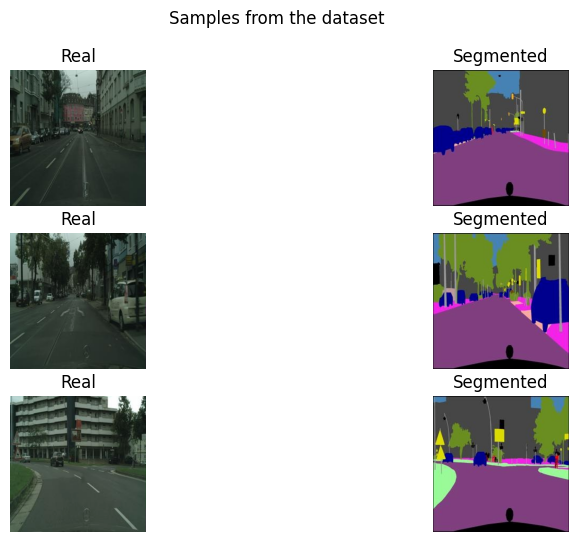

In [6]:
fig, axs = plt.subplots(3, 2, figsize=(10, 6))

for ax in axs:
    idx = np.random.randint(0, len(train_set))
    real, segm = train_set[idx]
    real = denormalize(real)
    segm = denormalize(segm)
    ax[0].imshow(real)
    ax[0].set_title('Real')
    ax[0].axis('off')
    ax[1].imshow(segm)
    ax[1].set_title('Segmented')
    ax[1].axis('off')

plt.suptitle('Samples from the dataset')
plt.show()

As described in the main paper, we use batch size $1$ which turns out to have better performance for this setting.

In [7]:
train_loader = DataLoader(train_set, batch_size=H['batch_size'], shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_set, batch_size=H['batch_size'], shuffle=False, num_workers=num_workers)

len(train_loader), len(val_loader)

(4, 2)

## Discriminator

The discriminator consist of a sequence of Convolution-BatchNorm-ReLU blocks. The generated-real recognition is done by classifying for $N\times N$ patches, then the final output of discriminator is the average of these results. This discriminator architecture is also called *PatchGAN*.

In [8]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, norm=True):
        super(ConvBlock, self).__init__()
        conv = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, padding=1, bias=not norm)
        batch_norm = nn.BatchNorm2d(out_channels)
        leaky_relu = nn.LeakyReLU(0.2, True)
        if norm:
            block = [conv, batch_norm, leaky_relu]
        else:
            block = [conv, leaky_relu]
        self.block = nn.Sequential(*block)

    def forward(self, x):
        return self.block(x)

class Discriminator(nn.Module):
    def __init__(self, input_nc=6, ndf=64):
        """Construct a PatchGAN discriminator

        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
        """
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            ConvBlock(input_nc, ndf, 2, norm=False),
            ConvBlock(ndf  , ndf*2, 2),
            ConvBlock(ndf*2, ndf*4, 2),
            ConvBlock(ndf*4, ndf*8, 1),
            nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, real, segm):
        input = torch.cat([real, segm], dim=1)
        return self.model(input)

discriminator = Discriminator(ndf=H['ndf']).to(device)

## Generator

In this framework, the generator has *U-Net* architecture. Note that all convolution blocks have kernel size $4$ and ther is no pooling layer. Using random noise for $z$ is not effective in this case, so we use dropout with high probability $0.5$ to add diversity to our generator. So at inference time, we do **not turn off dropout**.

In [11]:
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels, outermost=False, innermost=False):
        super(DownSample, self).__init__()
        leaky_relu = nn.LeakyReLU(0.2, True)
        conv = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=outermost)
        batch_norm = nn.BatchNorm2d(out_channels)
        if outermost:
            down = [conv]
        elif innermost:
            down = [leaky_relu, conv]
        else:
            down = [leaky_relu, conv, batch_norm]
        self.block = nn.Sequential(*down)

    def forward(self, x):
        return self.block(x)

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels, outermost=False, innermost=False, dropout=0):
        super(UpSample, self).__init__()
        in_mult = 1 if innermost else 2
        upconv = nn.ConvTranspose2d(in_channels * in_mult, out_channels, kernel_size=4, stride=2, padding=1)
        relu = nn.ReLU(True)
        batch_norm = nn.BatchNorm2d(out_channels)
        if outermost:
            up = [relu, upconv, nn.Tanh()]
        else:
            up = [relu, upconv, batch_norm]
        if dropout > 0:
            up.append(nn.Dropout(dropout))
        self.block = nn.Sequential(*up)

    def forward(self, x):
        return self.block(x)

class UnetSkipConnectionBlock(nn.Module):
    """Defines the Unet submodule with skip connection.
        X -------------------identity----------------------
        |-- downsampling -- |submodule| -- upsampling --|
    """

    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, dropout=0):
        """Construct a Unet submodule with skip connections.

        Parameters:
            outer_nc (int) -- the number of filters in the outer conv layer
            inner_nc (int) -- the number of filters in the inner conv layer
            input_nc (int) -- the number of channels in input images/features
            submodule (UnetSkipConnectionBlock) -- previously defined submodules
            outermost (bool)    -- if this module is the outermost module
            innermost (bool)    -- if this module is the innermost module
            dropout (float)  -- for dropout layers
        """
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if input_nc is None:
            input_nc = outer_nc
        down = DownSample(input_nc, inner_nc, outermost, innermost)
        up = UpSample(inner_nc, outer_nc, outermost, innermost, dropout)
        if innermost:
            model = [down, up]
        else:
            model = [down, submodule, up]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)

class Generator(nn.Module):
    def __init__(self, input_nc=3, output_nc=3, num_downs=8, ngf=64, dropout=0):
        """Construct a Unet generator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            output_nc (int) -- the number of channels in output images
            num_downs (int) -- the number of downsamplings in UNet. For example, # if |num_downs| == 7,
                                image of size 128x128 will become of size 1x1 # at the bottleneck
            ngf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer

        We construct the U-Net from the innermost layer to the outermost layer.
        It is a recursive process.
        """
        super(Generator, self).__init__()
        # construct unet structure
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, innermost=True)  # add the innermost layer
        for i in range(num_downs - 5):          # add intermediate layers with ngf * 8 filters
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, submodule=unet_block, dropout=dropout)
        # gradually reduce the number of filters from ngf * 8 to ngf
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, submodule=unet_block)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, submodule=unet_block)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, submodule=unet_block)
        self.model = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True)  # add the outermost layer

    def forward(self, input):
        return self.model(input)

generator = Generator(ngf=H['ngf'], dropout=H['dropout']).to(device)

The following cell is good to get familiar with dimensions in our problem.

In [10]:
for real, segm in train_loader:
    real, segm = real.to(device), segm.to(device)
    print(f'real.shape={real.shape}, segm.shape={segm.shape}')
    d_out = discriminator(real, segm)
    print(f'd_out.shape={d_out.shape}')
    g_out = generator(segm)
    print(f'g_out.shape={g_out.shape}')
    break

def count_params(model):
    return sum(p.numel() for p in model.parameters()) / 1e6

print(f'Number of parameters: Generator={count_params(generator):.2f}M, Discriminator={count_params(discriminator):.2f}M')

real.shape=torch.Size([2, 3, 256, 256]), segm.shape=torch.Size([2, 3, 256, 256])
d_out.shape=torch.Size([2, 1, 30, 30])
g_out.shape=torch.Size([2, 3, 256, 256])
Number of parameters: Generator=0.21M, Discriminator=0.01M


## Loss function

The discriminator loss is devided by $2$ to slow down the rate of learning for $D$.

$$
\mathcal{L}_D = -0.5 \big(\mathbb{E}_{x,y}[\log D(x,y)] + \mathbb{E}_{x,z}[\log (1-D(x, G(x,z)))]\big)
$$

The effect of L-1 loss for generator is controlled by hyper-parameter $\lambda$. Also it is usual to optimize $-\log(D)$ instead of $\log(1-D)$, because of gradient reasons. So the following is the final generator loss function.

$$
\mathcal{L}_G = -\mathbb{E}_{x,z}[\log D(x, G(x,z))] + \lambda \mathbb{E}_{x,z,y}\big[|| y-G(x, z) ||_1\big]
$$

In [12]:
def get_target(pred, is_true: bool):
    if is_true:
        return torch.ones_like(pred)
    else:
        return torch.zeros_like(pred)

def get_d_loss(d_model, g_model, real, segm):
    d_out_true = d_model(real, segm)
    loss_true = F.binary_cross_entropy_with_logits(d_out_true, get_target(d_out_true, True))
    with torch.no_grad():
        g_out = g_model(segm)
    d_out_false = d_model(g_out, segm)
    loss_false = F.binary_cross_entropy_with_logits(d_out_false, get_target(d_out_false, False))
    return 0.5 * (loss_true + loss_false)

def get_g_loss(d_model, g_model, real, segm, _lambda=H['lambda']):
    g_out = g_model(segm)
    d_out_false = d_model(g_out, segm)
    disc_loss = F.binary_cross_entropy_with_logits(d_out_false, get_target(d_out_false, True))
    l1_loss = F.l1_loss(g_out, real)
    return disc_loss + _lambda * l1_loss

## Optimizer

Adam solver is used as an optimizer. For training more efficiently, cosine annealing as scheduler is used.

In [13]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=H['lr'], betas=(H['beta1'], 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=H['lr'], betas=(H['beta1'], 0.999))

total_steps = len(train_loader) * H['num_epochs']
warmup_steps = total_steps // 10
d_scheduler = get_cosine_schedule_with_warmup(d_optimizer, total_steps, warmup_steps)
g_scheduler = get_cosine_schedule_with_warmup(g_optimizer, total_steps, warmup_steps)

## Hyper-parameters

Most of the hyper-parameters are identical to those in the main paper. Here is the full list:

- **learning rate:** For both discriminator and generator is $0.0002$
- **beta1:** In Adam optimizer $0.5$
- **lambda:** Importance of L-1 loss $10$
- **number of epochs:** $50$, in the main paper $200$
- **batch_size:** $1$
- **dropout:** For some blocks in the decoder of U-Net in generator $0.5$
- **ndf** and **ngf:** Number of filters in discriminator and generator $64$

## Train

The training time for $50$ epochs is less than $3$ hours on Kaggle GPU. Note that the generator is always in train mode.

In [14]:
def train(d_model, g_model, train_loader, d_optimizer, g_optimizer, d_scheduler, g_scheduler, device):
    d_loss_epoch = 0
    g_loss_epoch = 0

    batch_freq = max(1, len(train_loader) // 10)
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc='Training')
    for i, (real, segm) in pbar:
        real, segm = real.to(device), segm.to(device)

        d_model.train()
        g_model.train()

        d_optimizer.zero_grad()
        d_loss = get_d_loss(d_model, g_model, real, segm)
        d_loss.backward()
        d_optimizer.step()

        d_model.eval()
        g_model.train()

        g_optimizer.zero_grad()
        g_loss = get_g_loss(d_model, g_model, real, segm)
        g_loss.backward()
        g_optimizer.step()

        d_scheduler.step()
        g_scheduler.step()
        d_loss_epoch += d_loss.item()
        g_loss_epoch += g_loss.item()

        if i % batch_freq == 0:
            pbar.set_postfix({'d_loss': f'{d_loss:.4f}', 'g_loss': f'{g_loss:.4f}', 'lr': f'{g_optimizer.param_groups[0]["lr"]:.3g}'})

    d_loss_epoch /= len(train_loader)
    g_loss_epoch /= len(train_loader)
    return d_loss_epoch, g_loss_epoch

@torch.no_grad()
def evaluate(d_model, g_model, val_loader, device):
    d_loss_epoch = 0
    g_loss_epoch = 0

    d_model.eval()
    g_model.train()

    batch_freq = max(1, len(val_loader) // 10)
    pbar = tqdm(enumerate(val_loader), total=len(val_loader), desc='Validation', leave=False)
    for i, (real, segm) in pbar:
        real, segm = real.to(device), segm.to(device)

        d_loss = get_d_loss(d_model, g_model, real, segm)

        g_loss = get_g_loss(d_model, g_model, real, segm)

        d_loss_epoch += d_loss.item()
        g_loss_epoch += g_loss.item()

        if i % batch_freq == 0:
            pbar.set_postfix({'d_loss': f'{d_loss:.4f}', 'g_loss': f'{g_loss:.4f}'})

    d_loss_epoch /= len(val_loader)
    g_loss_epoch /= len(val_loader)
    return d_loss_epoch, g_loss_epoch

@torch.no_grad()
def visualize(g_model, val_loader, device, n_v=2, n_h=2):
    g_model.train()
    fig, axs = plt.subplots(n_v, n_h*3, figsize=(20, 8))

    for i, (real, segm) in enumerate(val_loader):
        if i >= n_v:
            break
        segm = segm.to(device)
        g_out = g_model(segm)

        s_tensors = segm.cpu()
        g_tensors = g_out.cpu()

        for j, (r_tensor, s_tensor, g_tensor) in enumerate(zip(real, s_tensors, g_tensors)):
            if j >= n_h:
                break
            axs[i, j*3].imshow(denormalize(s_tensor))
            axs[i, j*3+1].imshow(denormalize(r_tensor))
            axs[i, j*3+2].imshow(denormalize(g_tensor))
            axs[i, j*3].set_title('Segmented')
            axs[i, j*3+1].set_title('Real')
            axs[i, j*3+2].set_title('Generated')
            axs[i, j*3].axis('off')
            axs[i, j*3+1].axis('off')
            axs[i, j*3+2].axis('off')

    plt.suptitle('Example results of Pix2Pix on Cityscapes')
    plt.show()

## Save

Some results from validation set has been showen every $10$ epochs.

Training: 100%|██████████| 4/4 [00:00<00:00,  6.31it/s, d_loss=0.7159, g_loss=7.3275, lr=6.67e-05]

Epoch 1/3, Train Loss: D=0.7220, G=7.1009


Validation Loss: D=0.6940, G=5.8513


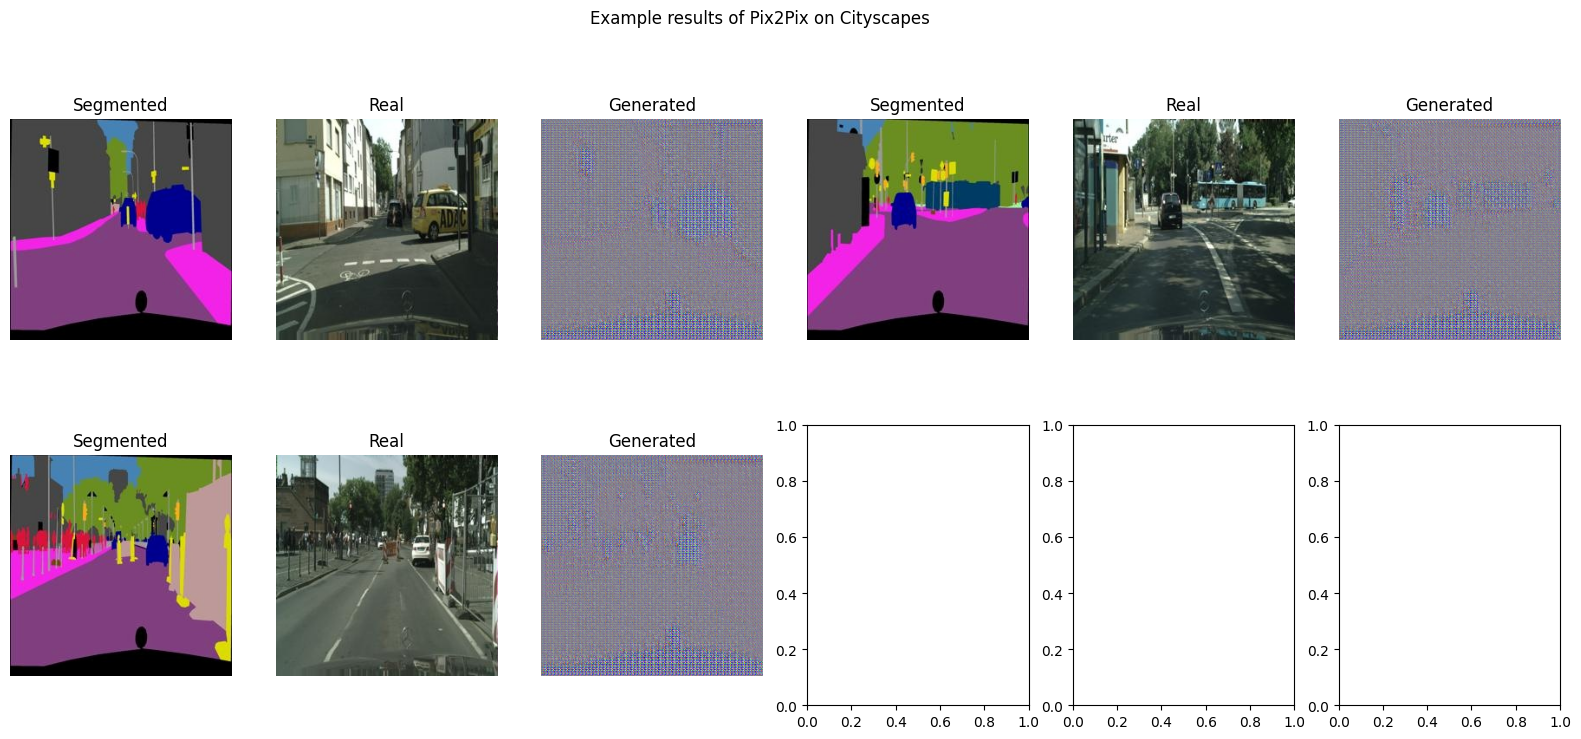

Training: 100%|██████████| 4/4 [00:00<00:00, 26.56it/s, d_loss=0.7154, g_loss=6.2039, lr=0.000133]

Epoch 2/3, Train Loss: D=0.7182, G=6.9332


Validation Loss: D=0.6946, G=5.8088


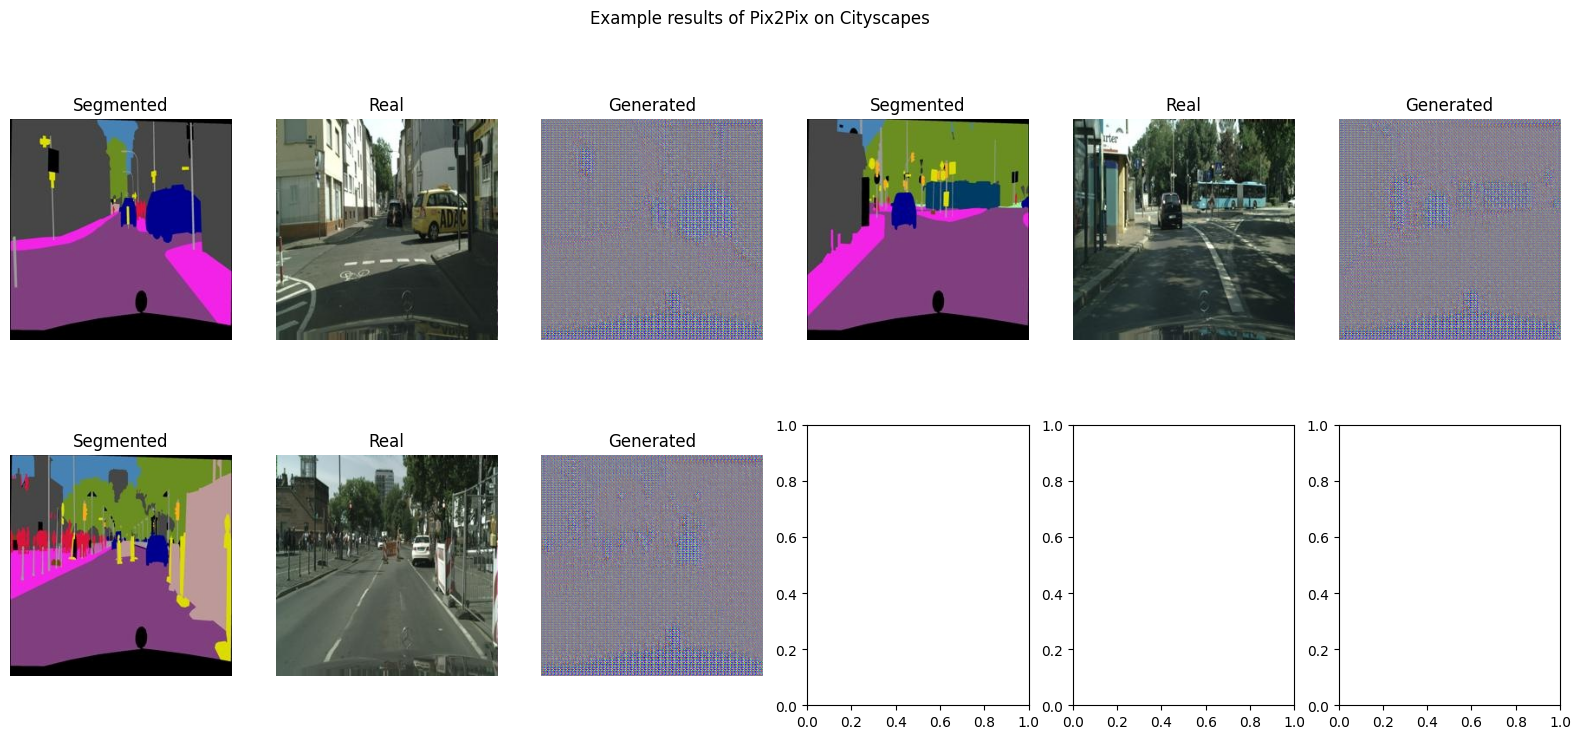

Training: 100%|██████████| 4/4 [00:00<00:00, 26.72it/s, d_loss=0.7043, g_loss=7.0600, lr=0.0002]  

Epoch 3/3, Train Loss: D=0.7085, G=6.9886


Validation Loss: D=0.6948, G=5.7547


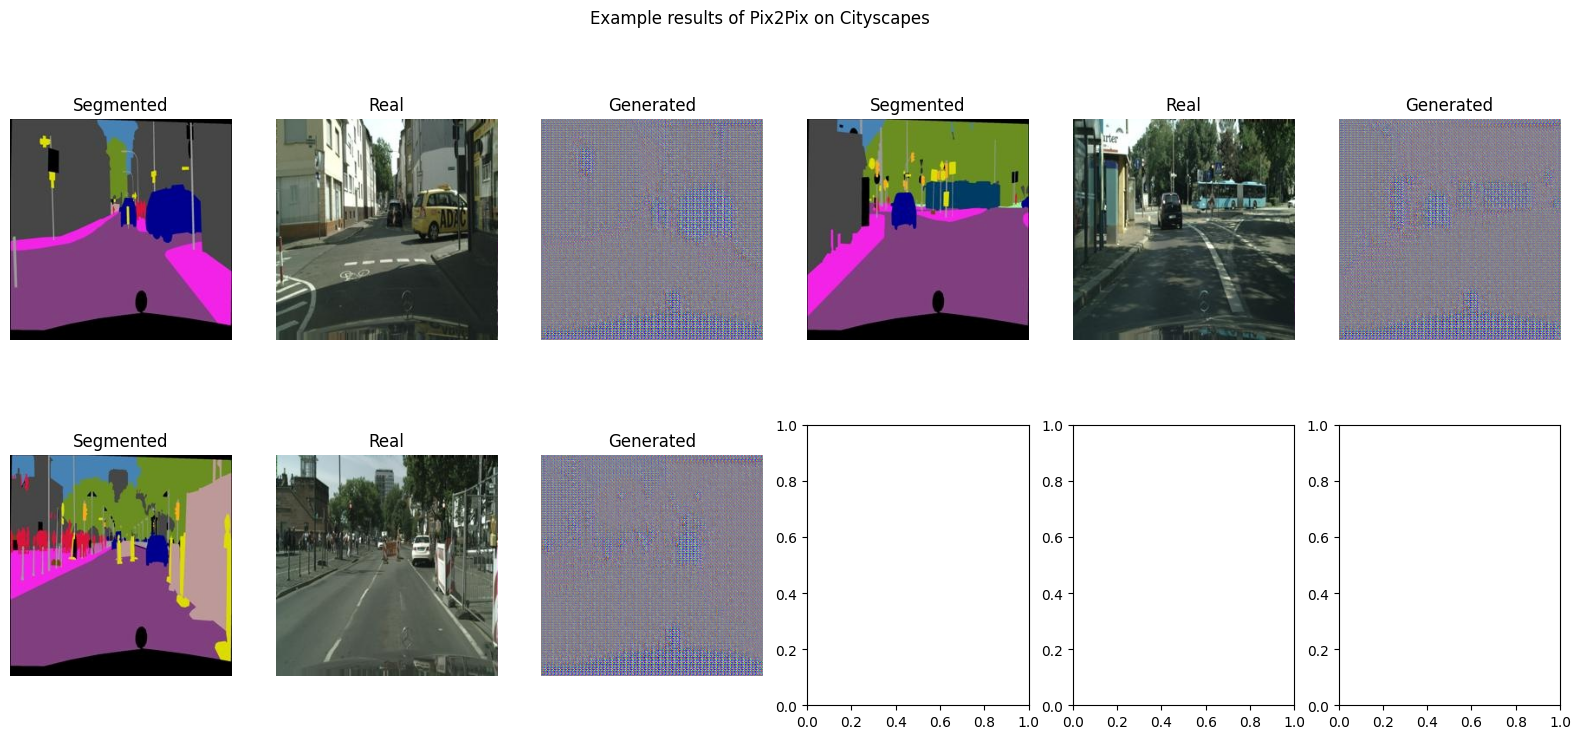

In [15]:
train_d_losses = []
train_g_losses = []
val_d_losses = []
val_g_losses = []

visual_freq = max(1, H['num_epochs'] // 5)
for epoch in range(1, H['num_epochs']+1):
    train_d_loss, train_g_loss = train(discriminator, generator, train_loader, d_optimizer, g_optimizer, d_scheduler, g_scheduler, device)
    print(f'Epoch {epoch}/{H["num_epochs"]}, Train Loss: D={train_d_loss:.4f}, G={train_g_loss:.4f}')
    val_d_loss, val_g_loss = evaluate(discriminator, generator, val_loader, device)
    print(f'Validation Loss: D={val_d_loss:.4f}, G={val_g_loss:.4f}')

    train_d_losses.append(train_d_loss)
    train_g_losses.append(train_g_loss)
    val_d_losses.append(val_d_loss)
    val_g_losses.append(val_g_loss)

    if (epoch-1) % visual_freq == 0:
        visualize(generator, val_loader, device)

torch.save(discriminator.state_dict(), 'discriminator.pth')
torch.save(generator.state_dict(), 'generator.pth')

## Epoch Losses

The generator and discriminator loss keeps oscillating during GAN training.

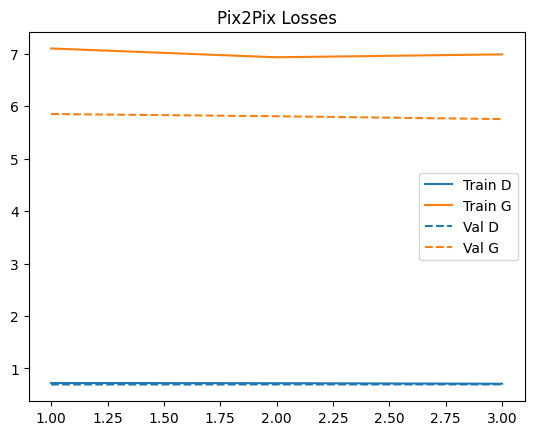

In [16]:
x = range(1, H['num_epochs']+1)
plt.plot(x, train_d_losses, label='Train D', c='tab:blue')
plt.plot(x, train_g_losses, label='Train G', c='tab:orange')
plt.plot(x, val_d_losses, label='Val D', c='tab:blue', linestyle='dashed')
plt.plot(x, val_g_losses, label='Val G', c='tab:orange', linestyle='dashed')

plt.title('Pix2Pix Losses')
plt.legend()
plt.show()

## Conclusion

Using U-Net as backbone architecture for generator and PatchGAN as discriminator, can result high-quality generated images. Batch size $1$ and high dropout increases the diversity. Pix2Pix is a very general-purpos framework for various paired image-to-image translation tasks.

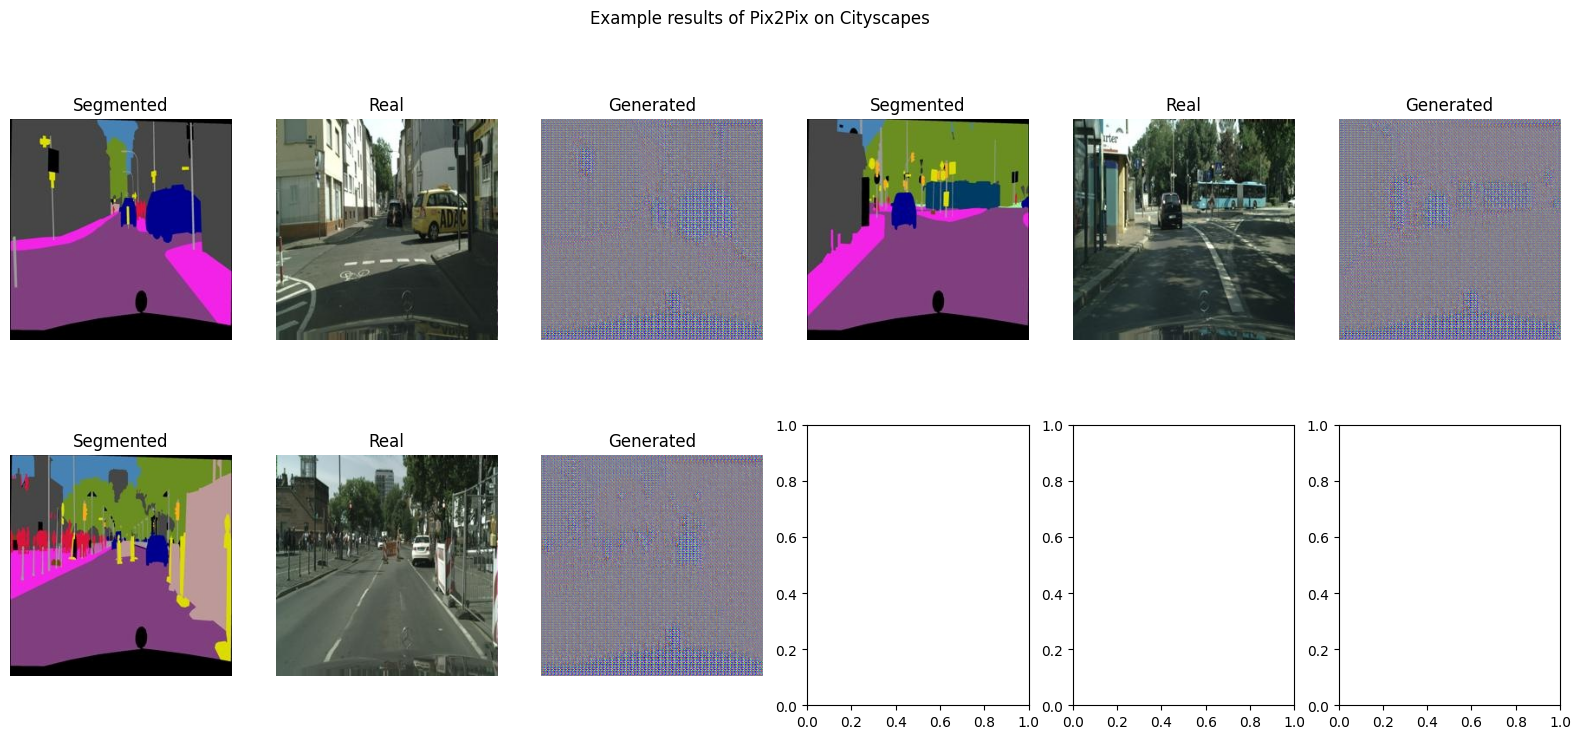

In [17]:
generator.load_state_dict(torch.load('generator.pth', map_location=device, weights_only=True))
visualize(generator, val_loader, device)